# Acquire the data

In [ ]:
import torch
from torchvision.datasets import FashionMNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)  # Set set for reproducibility for PyTorch

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))]) # Setting mean and std to 0.5 since ToTensor() will make the values between 0-1. Although, 0.5 is not the actual mean or std, it is usually good enough

# Load Fashion MNIST dataset
trainset_fashionmnist = FashionMNIST(root='../data', train=True, transform=transform, download=True)
testset_fashionmnist = FashionMNIST(root='../data', train=False, transform=transform, download=True)

# Load Fashion CIFAR10 dataset
trainset_cifar10 = CIFAR10(root='../data', train=True, transform=transform, download=True)
testset_cifar10 = CIFAR10(root='../data', train=False, transform=transform, download=True)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32  # Get the initial seed from PyTorch and convert to 32-bit integer
    random.seed(worker_seed)  # Set the random seed for the worker
    np.random.seed(worker_seed)  # Set the random seed for NumPy (if used)

# Create data loaders for training and testing
trainloader_fashionmnist = DataLoader(trainset_fashionmnist, batch_size=64, shuffle=True, worker_init_fn=seed_worker)
testloader_fashionmnist = DataLoader(testset_fashionmnist, batch_size=64, shuffle=True, worker_init_fn=seed_worker)

trainloader_cifar10 = DataLoader(trainset_cifar10, batch_size=64, shuffle=True, worker_init_fn=seed_worker)
testloader_cifar10 = DataLoader(testset_cifar10, batch_size=64, shuffle=True, worker_init_fn=seed_worker)





100%|██████████| 26421880/26421880 [00:01<00:00, 15980666.11it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270967.19it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4982777.04it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11962480.33it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 170498071/170498071 [00:01<00:00, 86141326.36it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


# Task 2: Implement a Multilayer Perceptron

## Activation Functions and their derivatives

In [ ]:
import numpy as np

def ReLU(Z):
  return np.maximum(Z, 0)

def ReLU_deriv(Z):
  return Z > 0

def sigmoid(Z):
  return 1 / (1 + np.exp(-Z))

def sigmoid_deriv(Z):
  A = sigmoid(Z)
  return A * (1 - A)

def tanh(Z):
  return np.tanh(Z)

def tanh_deriv(Z):
  A = tanh(Z)
  return 1 - A**2

def softmax(Z):
  A = np.exp(Z) / sum(np.exp(Z))
  return A

In [ ]:
def evaluate_acc(y_true, y_pred):
  N = len(y_true)
  num_correct_pred = 0

  for true, pred in zip(y_true, y_pred):
    if true == pred:
      num_correct_pred += 1

  acc = num_correct_pred / N
  return acc


In [ ]:
class MLP():
  def __init__(self, input_size, hidden_layers, num_units, output_size, activation_function='relu', initializer='Gaussian N(0,1)'):
    self.layer_sizes = [input_size] + num_units + [output_size] # Concatenate to get a list where element i represent the number of units at layer i
    self.activation_function_name = activation_function

    self.initializer = initializer

    # Iniatialize weights and biases
    self.initialize_weights_and_biases()

  def initialize_weights_and_biases(self):
    np.random.seed(42)  # For reproducibility

    if self.initializer == 'Gaussian N(0,1)':
      params = {}
      for i in range(1, len(self.layer_sizes)):
        params[f'W{i}'] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i - 1]) * 0.01 # W1 is the weight matrix for input layer and first hidden layer. Let len(layer_sizes) = h. Wh-1 is the weight matrix for last hidden layer and output layer
        params[f'b{i}'] = np.random.randn(self.layer_sizes[i], 1)
      self.params = params

    elif self.initializer == 'all zeros':
      params = {}
      for i in range(1, len(self.layer_sizes)):
        params[f'W{i}'] = np.zeros((self.layer_sizes[i], self.layer_sizes[i - 1]))
        params[f'b{i}'] = np.zeros((self.layer_sizes[i], 1))
      self.params = params

    elif self.initializer == 'Uniform [-1, 1]':
      params = {}
      for i in range(1, len(self.layer_sizes)):
        params[f'W{i}'] = np.random.uniform(-1, 1, size=(self.layer_sizes[i], self.layer_sizes[i - 1])) # (output_size, input_size)
        params[f'b{i}'] = np.random.uniform(-1, 1, size=(self.layer_sizes[i], 1))
      self.params = params

    elif self.initializer == 'Xavier':
      params = {}
      for i in range(1, len(self.layer_sizes)):
        # Calculate the limit for Xavier initialization for that layer
        xavier_limit = np.sqrt(2 / (self.layer_sizes[i - 1] + self.layer_sizes[i]))

        params[f'W{i}'] = np.random.uniform(-xavier_limit, xavier_limit, size=(self.layer_sizes[i], self.layer_sizes[i - 1]))
        params[f'b{i}'] = np.random.uniform(-xavier_limit, xavier_limit, size=(self.layer_sizes[i], 1))
      self.params = params

    elif self.initializer == 'Kaiming':
      params = {}
      for i in range(1, len(self.layer_sizes)):
        # Calculate the limit for Kaiming initialization for that layer
        kaiming_limit = np.sqrt(2 / (self.layer_sizes[i - 1]))

        params[f'W{i}'] = np.random.normal(0, kaiming_limit, size=(self.layer_sizes[i], self.layer_sizes[i - 1]))
        params[f'b{i}'] = np.random.normal(0, kaiming_limit, size=(self.layer_sizes[i], 1))
      self.params = params


  def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, 10)) # N x 10
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T # 10 x N
    return one_hot_Y

  def forward_prop(self, params, X):
    A = X
    cache = {"A0": A} # cache will store the weighted sum, Z{l} and activation, A{l} for each layer. A0 is activation output of input layer which is equal to the input

    for l in range(1, len(params) // 2 + 1):
      W = params[f'W{l}']
      b = params[f'b{l}']
      Z = np.dot(W, A) + b
      A = self.activation_func(Z) if l < len(params) // 2 else softmax(Z) # len(params) // 2 represents the index for the last weight matrix, i.e the weight matrix for the last hidden layer and output layer
      cache[f'Z{l}'] = Z # Shape: Size of Layer l * Number of data points in X
      cache[f'A{l}'] = A # A1 is the activation function output of first hidden layer

    return A, cache

  def backward_prop(self, params, cache, X, Y, regularization_type=None, lambd=0.01):
    grads = {}
    m = X.shape[1] # m is the number of training data points in batch X
    L = len(params) // 2 # Index of last layer, i.e output layer
    one_hot_Y = MLP.one_hot(Y)

    dA = cache[f'A{L}'] - one_hot_Y # cache[f'A{L}'] is output layer values, both output layer and one_hot_Y are 10 x N matrices

    for l in range(L, 0, -1):
      Z = cache[f'Z{l}']
      W = params[f'W{l}']

      dZ = dA
      if l < L: # If not last layer
          dZ = dA * self.activation_deriv_func(Z)

      A_prev = cache[f'A{l-1}'] if l > 1 else X

      regularization = 0
      if regularization_type == 'L2':
        regularization = (lambd / m) * W
      elif regularization_type == 'L1':
        regularization = (lambd / m) * np.sign(W)

      grads[f'dW{l}'] = (1 / m) * np.dot(dZ, A_prev.T) + regularization
      grads[f'db{l}'] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)

      if l > 1:
        dA = np.dot(W.T, dZ)

    return grads

  def get_activation_func(function_name: str):
    activation_func = ReLU
    if function_name == 'sigmoid':
      activation_func = sigmoid
    elif function_name == 'tanh':
      activation_func = tanh
    return activation_func

  def get_activation_deriv_func(function_name: str):
    activation_deriv_func = ReLU_deriv
    if function_name == 'sigmoid':
      activation_func = sigmoid_deriv
    elif function_name == 'tanh':
      activation_func = tanh_deriv
    return activation_deriv_func

  def fit(self, data_loader, learning_rate, num_iterations, regularization_type=None, lambd=0.01, image_size=784):
    # Get the activation function and its derivative of the one chosen by the user
    self.activation_func = MLP.get_activation_func(self.activation_function_name)
    self.activation_deriv_func = MLP.get_activation_deriv_func(self.activation_function_name)

    y_true = []
    y_pred = []

    iterations = []
    accuracy_list = []

    for i in range(num_iterations):
      for images, labels in data_loader:
        #print(images.shape)  # This will be the first data sample in its normalized form
        #print(batch_labels) # labels are from 0 to 9

        # Move tensor to the same device (CPU/GPU) as the model
        #X, Y = images.to(device), batch_labels.to(device)

        # Flatten the images
        X = images.view(-1, image_size).T
        X = X.numpy() # shape (784, 64). images was orginally torch.Size([64, 1, 28, 28]). So, a full column represent a data point (not a row)

        #print(X.shape) # 3072 x 64 for cifar10
        y = labels # 1D array of length 64
        y = y.numpy()

        A, cache = self.forward_prop(self.params, X) # ()

        yh = np.argmax(A, 0)

        y_true += y.tolist() # convert y from np array to normal python list
        y_pred += yh.tolist()

        grads = self.backward_prop(self.params, cache, X, y, regularization_type, lambd)

        # Update the weights and biases for that layer
        for l in range(1, len(self.params) // 2 + 1):
          self.params[f'W{l}'] = self.params[f'W{l}'] - learning_rate * grads[f'dW{l}']
          self.params[f'b{l}'] = self.params[f'b{l}'] - learning_rate * grads[f'db{l}']

      acc = evaluate_acc(y_true, y_pred)
      iterations.append(i+1)
      accuracy_list.append(acc)

      print(f"Iteration {i+1}: Training accuracy: {acc}")

    print("Iterations", iterations)
    print("Accuracies", accuracy_list)

  def predict(self, X): # X is not a dataloader. It is a numpy array already flattened and transposed, for e.g (784, N)
    yh, cache = self.forward_prop(self.params, X)
    # Returns a 1D array representing the predicted label for each data point in X
    return np.argmax(yh, 0) # Get the index of the max value along all the rows(0 represents along rows) for each column. Remember yh is 10xN. So, each row is a value for the probability of each label





In [ ]:
def get_accuracy_dataloader(model, dataloader, image_size=784):
  y_true = []
  y_pred = []

  for images, labels in dataloader:
      X = images.view(-1, image_size).T
      X = X.numpy() # shape (784, 64). images was orginally torch.Size([64, 1, 28, 28])
      y = labels # 1D array of length 64
      y = y.numpy()

      #print(Y.shape)
      #print(images.shape)

      yh = model.predict(X)

      y_true += y.tolist() # convert y from np array to normal python list
      y_pred += yh.tolist()

  acc = evaluate_acc(y_true, y_pred)
  return acc

# Task 3: Run the experiments and report

## Experiment with Learning Rates

Iteration 1: Training accuracy: 0.65645
Iteration 2: Training accuracy: 0.7225333333333334
Iteration 3: Training accuracy: 0.7547166666666667
Iteration 4: Training accuracy: 0.774025
Iteration 5: Training accuracy: 0.7873666666666667
Iterations [1, 2, 3, 4, 5]
Accuracies [0.65645, 0.7225333333333334, 0.7547166666666667, 0.774025, 0.7873666666666667]
Iteration 1: Training accuracy: 0.7788833333333334
Iteration 2: Training accuracy: 0.8130916666666667
Iteration 3: Training accuracy: 0.8289666666666666
Iteration 4: Training accuracy: 0.8392541666666666
Iteration 5: Training accuracy: 0.8468633333333333
Iterations [1, 2, 3, 4, 5]
Accuracies [0.7788833333333334, 0.8130916666666667, 0.8289666666666666, 0.8392541666666666, 0.8468633333333333]
Iteration 1: Training accuracy: 0.7844833333333333
Iteration 2: Training accuracy: 0.8169
Iteration 3: Training accuracy: 0.8324166666666667
Iteration 4: Training accuracy: 0.8426958333333333
Iteration 5: Training accuracy: 0.8501666666666666
Iterations 

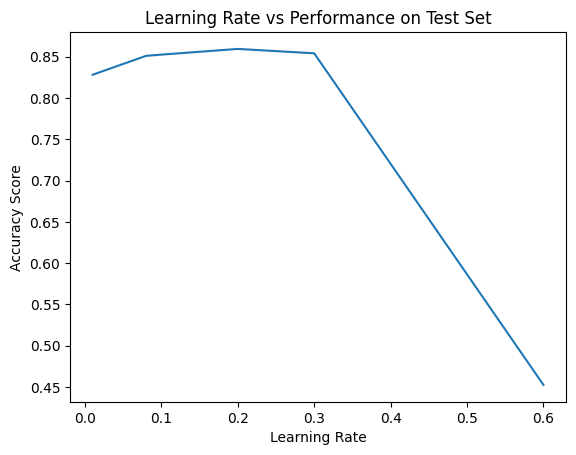

In [ ]:
learning_rates = [0.01, 0.08, 0.1, 0.2, 0.3, 0.6]
accuracy_per_learning_rates = []

for lr in learning_rates:
  model = MLP(784, 1, [128], 10)
  model.fit(trainloader_fashionmnist, learning_rate=lr, num_iterations=5)
  acc = get_accuracy_dataloader(model, testloader_fashionmnist)
  accuracy_per_learning_rates.append(acc)

plt.plot(learning_rates, accuracy_per_learning_rates)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy Score")
plt.title("Learning Rate vs Performance on Test Set")

print(accuracy_per_learning_rates)

A good learning rate is 0.2

## Task 3.1: Experiment with weight initialization

In [ ]:
# Initializing weights to all zeros
print("All zeros")
model_all_zeros = MLP(784, 1, [128], 10, 'relu', initializer='all zeros')
model_all_zeros.fit(trainloader_fashionmnist, learning_rate=0.2, num_iterations=6)

print()
# Initializing weights to Uniform [-1, 1]
print("Uniform [-1, 1]")
model_uniform = MLP(784, 1, [128], 10, 'relu', initializer='Uniform [-1, 1]')
model_uniform.fit(trainloader_fashionmnist, learning_rate=0.2, num_iterations=6)

print()
# Initializing weights to Gaussian N(0,1)
print("GaussianN(0,1)")
model_gaussian = MLP(784, 1, [128], 10, 'relu', initializer='Gaussian N(0,1)')
model_gaussian.fit(trainloader_fashionmnist, learning_rate=0.2, num_iterations=6)

print()
# Initializing weights to Xavier
print("Xavier")
model_xavier = MLP(784, 1, [128], 10, 'relu', initializer='Xavier')
model_xavier.fit(trainloader_fashionmnist, learning_rate=0.2, num_iterations=6)

print()
# Initializing weights to Kaiming
print("Kaiming")
model_kaiming = MLP(784, 1, [128], 10, 'relu', initializer='Kaiming')
model_kaiming.fit(trainloader_fashionmnist, learning_rate=0.2, num_iterations=6)

All zeros
Iteration 1: Training accuracy: 0.0976
Iteration 2: Training accuracy: 0.09886666666666667
Iteration 3: Training accuracy: 0.0989388888888889
Iteration 4: Training accuracy: 0.0995
Iteration 5: Training accuracy: 0.09905
Iteration 6: Training accuracy: 0.09898333333333334
Iterations [1, 2, 3, 4, 5, 6]
Accuracies [0.0976, 0.09886666666666667, 0.0989388888888889, 0.0995, 0.09905, 0.09898333333333334]

Uniform [-1, 1]


<ipython-input-10-54d43d032b4b>:24: RuntimeWarning: overflow encountered in exp
  A = np.exp(Z) / sum(np.exp(Z))
<ipython-input-10-54d43d032b4b>:24: RuntimeWarning: invalid value encountered in divide
  A = np.exp(Z) / sum(np.exp(Z))


Iteration 1: Training accuracy: 0.09993333333333333
Iteration 2: Training accuracy: 0.09996666666666666
Iteration 3: Training accuracy: 0.09997777777777778
Iteration 4: Training accuracy: 0.09998333333333333
Iteration 5: Training accuracy: 0.09998666666666667
Iteration 6: Training accuracy: 0.09998888888888889
Iterations [1, 2, 3, 4, 5, 6]
Accuracies [0.09993333333333333, 0.09996666666666666, 0.09997777777777778, 0.09998333333333333, 0.09998666666666667, 0.09998888888888889]

GaussianN(0,1)
Iteration 1: Training accuracy: 0.78855
Iteration 2: Training accuracy: 0.8182
Iteration 3: Training accuracy: 0.8332166666666667
Iteration 4: Training accuracy: 0.843125
Iteration 5: Training accuracy: 0.8507233333333334
Iteration 6: Training accuracy: 0.8564555555555555
Iterations [1, 2, 3, 4, 5, 6]
Accuracies [0.78855, 0.8182, 0.8332166666666667, 0.843125, 0.8507233333333334, 0.8564555555555555]

Xavier
Iteration 1: Training accuracy: 0.8005666666666666
Iteration 2: Training accuracy: 0.828325
It

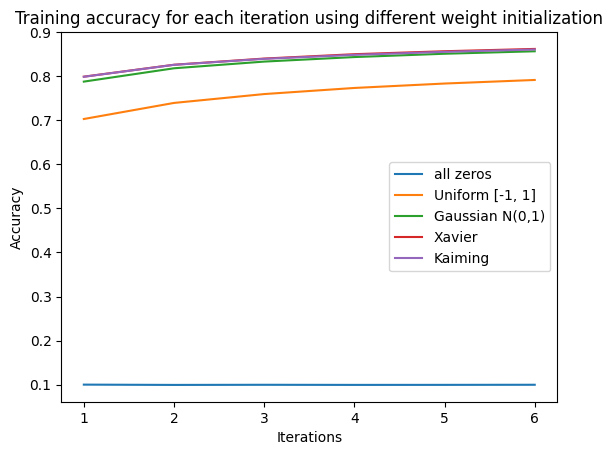

In [ ]:
# Comparing effect of weight initialization on training accuracy for each iteration
n = 6
iterations = []
for i in range(n):
  iterations.append(i+1)

all_zeros_accuracy_per_iteration = [0.09993333333333333, 0.09925833333333334, 0.09956111111111111, 0.0993125, 0.09939, 0.09961944444444444]
uniform_accuracy_per_iteration = [0.7030666666666666, 0.7395666666666667, 0.7596944444444444, 0.7735625, 0.7836033333333333, 0.7917138888888889]
gaussian_accuracy_per_iteration = [0.7879666666666667, 0.8182333333333334, 0.8334388888888888, 0.8437166666666667, 0.8512266666666667, 0.8568444444444444]
xavier_accuracy_per_iteration = [0.7991833333333334, 0.8262833333333334, 0.8403166666666667, 0.8502291666666667, 0.8569633333333333, 0.8621972222222222]
kaiming_accuracy_per_iteration = [0.79895, 0.8260666666666666, 0.8396555555555556, 0.8486958333333333, 0.8555366666666666, 0.86085]

fig, ax = plt.subplots()

# Plot each line on the same graph
ax.plot(iterations, all_zeros_accuracy_per_iteration, label='all zeros')
ax.plot(iterations, uniform_accuracy_per_iteration, label='Uniform [-1, 1]')
ax.plot(iterations, gaussian_accuracy_per_iteration, label='Gaussian N(0,1)')
ax.plot(iterations, xavier_accuracy_per_iteration, label='Xavier')
ax.plot(iterations, kaiming_accuracy_per_iteration, label='Kaiming')

# Set labels and a legend
ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy')
ax.set_title('Training accuracy for each iteration using different weight initialization')
ax.legend()

# Show the plot
plt.show()



All zeros is clearly the worst initialization for this example. Uniform [1,1] is also not great, and one reason could be because it produced a couple of overflows. Gaussian N(0,10), Xavier and Kaiming all produced good and very similar results on the training accuracy

[['all zeros', 0.1], ['Uniform [-1, 1]', 0.1], ['Xavier', 0.8631], ['Gaussian N(0,1)', 0.8636], ['Kaiming', 0.8717]]


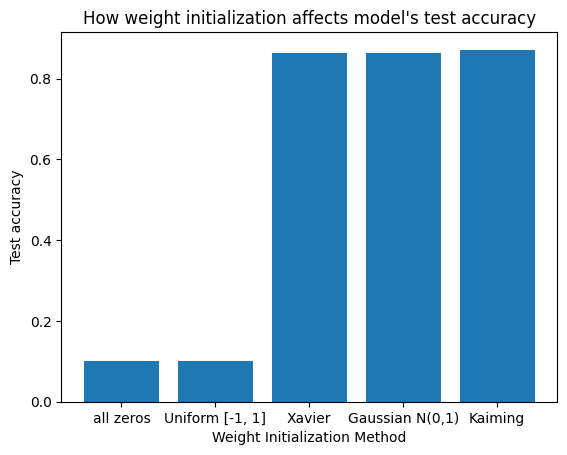

In [ ]:
# Comparing test accuracy for each weight initialization method

# List that stores tuples of weight initialization and test accuracy, for e.g [["all zeros", 0.09]]
initialization_accuracy = []

acc = get_accuracy_dataloader(model_all_zeros, testloader_fashionmnist)
initialization_accuracy.append(["all zeros", acc])

acc = get_accuracy_dataloader(model_uniform, testloader_fashionmnist)
initialization_accuracy.append(["Uniform [-1, 1]", acc])

acc = get_accuracy_dataloader(model_gaussian, testloader_fashionmnist)
initialization_accuracy.append(["Gaussian N(0,1)", acc])

acc = get_accuracy_dataloader(model_xavier, testloader_fashionmnist)
initialization_accuracy.append(["Xavier", acc])

acc = get_accuracy_dataloader(model_kaiming, testloader_fashionmnist)
initialization_accuracy.append(["Kaiming", acc])

# Sort by best accuracy
initialization_accuracy = sorted(initialization_accuracy, key=lambda item: item[1])

print(initialization_accuracy)

initialization_method = []
accuracy = []
for i, a in initialization_accuracy:
  initialization_method.append(i)
  accuracy.append(a)

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

# Plot the bar chart
ax.bar(initialization_method, accuracy)

# Set labels and a title
ax.set_xlabel('Weight Initialization Method')
ax.set_ylabel('Test accuracy')
ax.set_title('How weight initialization affects model\'s test accuracy')

# Show the plot
plt.show()




Kaiming, Gaussian and Xavier have very similar accuracy score on test set with kaiming having the highest with a test score of 87.2 %.

## Task 3.2: Varying number of hidden layers

In [ ]:
# an MLP with no hidden layers
model_no_hidden_layers = MLP(784, 0, [], 10)
model_no_hidden_layers.fit(trainloader_fashionmnist, learning_rate=0.2,  num_iterations=6)

# an MLP with a single hidden layer having 128 units and ReLU activations
model_single_hidden_layer = MLP(784, 1, [128], 10, activation_function='relu')
model_single_hidden_layer.fit(trainloader_fashionmnist, learning_rate=0.2, num_iterations=6)

#  an MLP with 2 hidden layers each having 128 units with ReLU activations
model_two_hidden_layers = MLP(784, 2, [128, 128], 10, activation_function='relu')
model_two_hidden_layers.fit(trainloader_fashionmnist, learning_rate=0.2, num_iterations=6)

Iteration 1: Training accuracy: 0.7593166666666666
Iteration 2: Training accuracy: 0.7774083333333334
Iteration 3: Training accuracy: 0.7880944444444444
Iteration 4: Training accuracy: 0.7939208333333333
Iteration 5: Training accuracy: 0.7975933333333334
Iteration 6: Training accuracy: 0.8008611111111111
Iterations [1, 2, 3, 4, 5, 6]
Accuracies [0.7593166666666666, 0.7774083333333334, 0.7880944444444444, 0.7939208333333333, 0.7975933333333334, 0.8008611111111111]
Iteration 1: Training accuracy: 0.7904
Iteration 2: Training accuracy: 0.8201833333333334
Iteration 3: Training accuracy: 0.8352277777777778
Iteration 4: Training accuracy: 0.8444958333333333
Iteration 5: Training accuracy: 0.85145
Iteration 6: Training accuracy: 0.8570666666666666
Iterations [1, 2, 3, 4, 5, 6]
Accuracies [0.7904, 0.8201833333333334, 0.8352277777777778, 0.8444958333333333, 0.85145, 0.8570666666666666]
Iteration 1: Training accuracy: 0.7297666666666667
Iteration 2: Training accuracy: 0.78565
Iteration 3: Traini

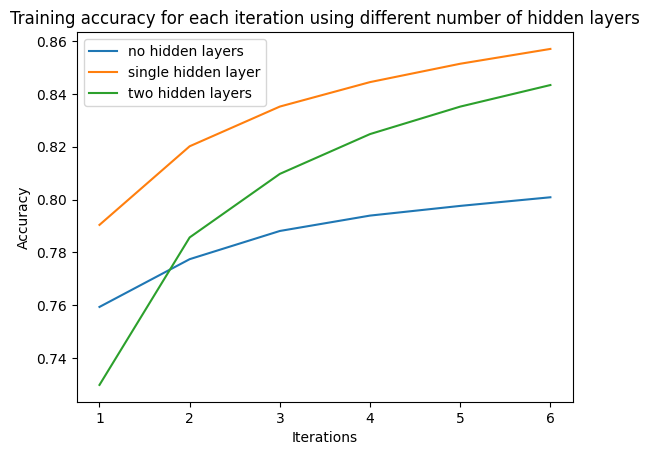

In [ ]:
# Comparing effect of number of hidden layers on training accuracy for each iteration
n = 6
iterations = []
for i in range(n):
  iterations.append(i+1)

no_hidden_layers_accuracy_per_iteration = [0.7593166666666666, 0.7774083333333334, 0.7880944444444444, 0.7939208333333333, 0.7975933333333334, 0.8008611111111111]
single_hidden_layer_accuracy_per_iteration = [0.7904, 0.8201833333333334, 0.8352277777777778, 0.8444958333333333, 0.85145, 0.8570666666666666]
two_hidden_layers_accuracy_per_iteration = [0.7297666666666667, 0.78565, 0.8097222222222222, 0.8248041666666667, 0.83521, 0.8433805555555556]

fig, ax = plt.subplots()

# Plot each line on the same graph
ax.plot(iterations, no_hidden_layers_accuracy_per_iteration, label='no hidden layers')
ax.plot(iterations, single_hidden_layer_accuracy_per_iteration, label='single hidden layer')
ax.plot(iterations, two_hidden_layers_accuracy_per_iteration, label='two hidden layers')


# Set labels and a legend
ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy')
ax.set_title('Training accuracy for each iteration using different number of hidden layers')
ax.legend()

# Show the plot
plt.show()



In [ ]:
acc = get_accuracy_dataloader(model_no_hidden_layers, testloader_fashionmnist)
print(f"Test Accuracy of model with no hidden layers {acc}")

acc = get_accuracy_dataloader(model_single_hidden_layer, testloader_fashionmnist)
print(f"Test Accuracy of model with single layers {acc}")

acc = get_accuracy_dataloader(model_two_hidden_layers, testloader_fashionmnist)
print(f"Test Accuracy of model with two hidden layers {acc}")

Test Accuracy of model with no hidden layers 0.6223
Test Accuracy of model with single layers 0.8619
Test Accuracy of model with no hidden layers 0.864


The test accuracy is definitely better with the models having one (86.2 %) or two hidden layers (86.4 %) compared to the model with no hidden layer (62.2 %). But, maybe surprisingly, the accuracy of the model with 2 hidden layers is a bit less than that of the model with only 1 hidden layer. This could mean the model with 2 hidden layers is starting to overfit a bit.

## Task 3.3: Varying activation function

In [ ]:
# sigmoid
model_sigmoid = MLP(784, 2, [128, 128], 10, activation_function='sigmoid')
model_sigmoid.fit(trainloader_fashionmnist, learning_rate=0.2, num_iterations=6)

# tanh
model_tanh = MLP(784, 2, [128, 128], 10, activation_function='tanh')
model_tanh.fit(trainloader_fashionmnist, learning_rate=0.2, num_iterations=6)

print(f"Test Accuracy of model with relu {acc}")

acc = get_accuracy_dataloader(model_sigmoid, testloader_fashionmnist)
print(f"Test Accuracy of model with sigmoid {acc}")

acc = get_accuracy_dataloader(model_tanh, testloader_fashionmnist)
print(f"Test Accuracy of model with tanh {acc}")


<ipython-input-10-54d43d032b4b>:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))


Iteration 1: Training accuracy: 0.28363333333333335
Iteration 2: Training accuracy: 0.3416416666666667
Iteration 3: Training accuracy: 0.40147777777777777
Iteration 4: Training accuracy: 0.4554
Iteration 5: Training accuracy: 0.49367
Iteration 6: Training accuracy: 0.5229777777777778
Iterations [1, 2, 3, 4, 5, 6]
Accuracies [0.28363333333333335, 0.3416416666666667, 0.40147777777777777, 0.4554, 0.49367, 0.5229777777777778]
Iteration 1: Training accuracy: 0.6270166666666667
Iteration 2: Training accuracy: 0.6888416666666667
Iteration 3: Training accuracy: 0.71425
Iteration 4: Training accuracy: 0.7289791666666666
Iteration 5: Training accuracy: 0.7393566666666667
Iteration 6: Training accuracy: 0.7477111111111111
Iterations [1, 2, 3, 4, 5, 6]
Accuracies [0.6270166666666667, 0.6888416666666667, 0.71425, 0.7289791666666666, 0.7393566666666667, 0.7477111111111111]
Test Accuracy of model with relu 0.864
Test Accuracy of model with sigmoid 0.6827
Test Accuracy of model with tanh 0.7634


From the experiment, using ReLu as the activation function clearly produces the model with the highest accuracy on the test set having a score of 86.4 %. Tanh produces the second best score having an accuracy of 76.34 %. Sigmoid produced the worst model, and one reason for that could be because it's more proned to running into overflow issues due to the exponent component.

## Task 3.4: Adding L1 and L2 regularization

In [ ]:
# L1
model_l1 = MLP(784, 2, [128, 128], 10)
model_l1.fit(trainloader_fashionmnist, learning_rate=0.2, num_iterations=6, regularization_type='L1')

# L2
model_l2 = MLP(784, 2, [128, 128], 10)
model_l2.fit(trainloader_fashionmnist, learning_rate=0.2, num_iterations=6, regularization_type='L2')

acc = get_accuracy_dataloader(model_l1, testloader_fashionmnist)
print(f"Test Accuracy of model with L1 Regularization {acc}")

acc = get_accuracy_dataloader(model_l2, testloader_fashionmnist)
print(f"Test Accuracy of model with L2 Regularization {acc}")

Iteration 1: Training accuracy: 0.7091
Iteration 2: Training accuracy: 0.7629083333333333
Iteration 3: Training accuracy: 0.7868666666666667
Iteration 4: Training accuracy: 0.8008083333333333
Iteration 5: Training accuracy: 0.8099
Iteration 6: Training accuracy: 0.81695
Iterations [1, 2, 3, 4, 5, 6]
Accuracies [0.7091, 0.7629083333333333, 0.7868666666666667, 0.8008083333333333, 0.8099, 0.81695]
Iteration 1: Training accuracy: 0.73325
Iteration 2: Training accuracy: 0.785975
Iteration 3: Training accuracy: 0.8099722222222222
Iteration 4: Training accuracy: 0.8246458333333333
Iteration 5: Training accuracy: 0.8344166666666667
Iteration 6: Training accuracy: 0.8422222222222222
Iterations [1, 2, 3, 4, 5, 6]
Accuracies [0.73325, 0.785975, 0.8099722222222222, 0.8246458333333333, 0.8344166666666667, 0.8422222222222222]
Test Accuracy of model with L1 Regularization 0.7211
Test Accuracy of model with L2 Regularization 0.8655


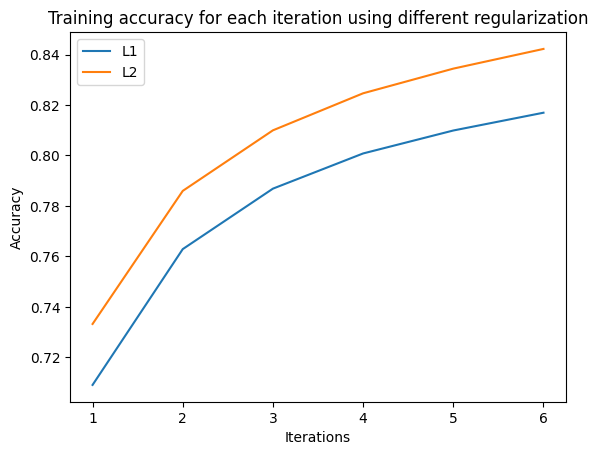

In [ ]:
# Comparing effect of number of hidden layers on training accuracy for each iteration
n = 6
iterations = []
for i in range(n):
  iterations.append(i+1)

l1_accuracy_per_iteration = [0.7091, 0.7629083333333333, 0.7868666666666667, 0.8008083333333333, 0.8099, 0.81695]
l2_accuracy_per_iteration = [0.73325, 0.785975, 0.8099722222222222, 0.8246458333333333, 0.8344166666666667, 0.8422222222222222]

fig, ax = plt.subplots()

# Plot each line on the same graph
ax.plot(iterations, l1_accuracy_per_iteration, label='L1')
ax.plot(iterations, l2_accuracy_per_iteration, label='L2')


# Set labels and a legend
ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy')
ax.set_title('Training accuracy for each iteration using different regularization')
ax.legend()

# Show the plot
plt.show()



The model using L2 regularization has an accuracy score of 86.6 %, which is very close to the accuracy score of the model with no regularization, which was 86.4 %. Using L1 regularization however, significantly decreased the test accuracy score and it's value is 72.1 %.

## Task 3.5: Training with unnormalized images

In [ ]:
trainset_fashionmnist = FashionMNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
testset_fashionmnist = FashionMNIST(root='../data', train=False, transform=transforms.ToTensor(), download=True)

# Create data loaders for training and testing
trainloader_fashionmnist_unnorm = DataLoader(trainset_fashionmnist, batch_size=64, shuffle=True, worker_init_fn=seed_worker)
testloader_fashionmnist_unnorm = DataLoader(testset_fashionmnist, batch_size=64, shuffle=True, worker_init_fn=seed_worker)


Iteration 1: Training accuracy: 0.6921833333333334
Iteration 2: Training accuracy: 0.762925
Iteration 3: Training accuracy: 0.7919722222222222
Iteration 4: Training accuracy: 0.8098416666666667
Iteration 5: Training accuracy: 0.8219233333333333


Iteration 6: Training accuracy: 0.8307583333333334
Iterations [1, 2, 3, 4, 5, 6]
Accuracies [0.6921833333333334, 0.762925, 0.7919722222222222, 0.8098416666666667, 0.8219233333333333, 0.8307583333333334]


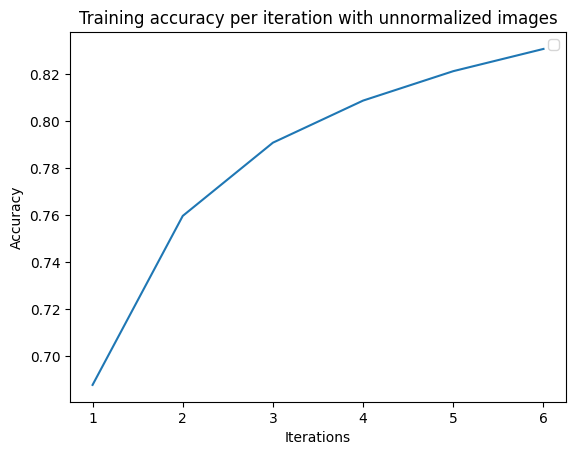

Test Accuracy of model unnormalized images 0.8439


In [ ]:
model_unnormalized_images = MLP(784, 2, [128, 128], 10)
model_unnormalized_images.fit(trainloader_fashionmnist_unnorm, learning_rate=0.2, num_iterations=6)

accuracy_per_iteration = [0.6877666666666666, 0.759625, 0.7907555555555555, 0.80865, 0.8211566666666666, 0.8306083333333333]

fig, ax = plt.subplots()

# Plot each line on the same graph
ax.plot(iterations, accuracy_per_iteration)

# Set labels and a legend
ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy')
ax.set_title('Training accuracy per iteration with unnormalized images')
ax.legend()

# Show the plot
plt.show()


acc = get_accuracy_dataloader(model_unnormalized_images, testloader_fashionmnist_unnorm)
print(f"Test Accuracy of model unnormalized images {acc}")

The test accuracy score is still pretty good for the model with unnormalized images having a score of 0.844. However, this good performance might be due to the `transforms.ToTensor()` which scales the pixel values to the range [0,1].

## Task 3.6: CNN using PyTorch

In [ ]:
import torch.nn as nn

X = None
for images, labels in trainloader_cifar10:
  X = images
  break

print(X.shape) #[64, 3, 32, 32] 64 is the number if images, 3 is the number of channels for each image, and 32x32 is the size of each image

conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
pool1 = nn.MaxPool2d(2, 2)
X = conv1(X)
print(X.shape)
X = pool1(X)
print(X.shape)

conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
pool2 = nn.MaxPool2d(2, 2)
X = conv2(X)
print(X.shape)
X = pool2(X)
print(X.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64, 32, 32, 32])
torch.Size([64, 32, 16, 16])
torch.Size([64, 64, 16, 16])
torch.Size([64, 64, 8, 8])


In [ ]:

# Define a CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1) # padding=1 ensures the image_size stay 28x28
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Input size depends on the chosen architecture
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)  # Output layer with 10 classes (Fashion MNIST)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the output
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x




In [ ]:
print(device)

model_cnn = CNN()
model_cnn.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.001)

# Train the CNN
num_epochs = 20
for epoch in range(num_epochs):
  for batch_id, (images, labels) in enumerate(trainloader_fashionmnist):
    # Move tensor to the same device (CPU/GPU) as the model
    images, labels = images.to(device), labels.to(device)

    # Forward pass
    outputs = model_cnn(images)
    loss = loss_func(outputs, labels)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if batch_id % 500 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")



cuda
Epoch: 1, Loss: 2.3105
Epoch: 1, Loss: 2.2940
Epoch: 2, Loss: 2.2705
Epoch: 2, Loss: 2.2470
Epoch: 3, Loss: 2.1982
Epoch: 3, Loss: 2.0248
Epoch: 4, Loss: 1.7097
Epoch: 4, Loss: 1.2753
Epoch: 5, Loss: 1.0130
Epoch: 5, Loss: 0.7209
Epoch: 6, Loss: 0.7738
Epoch: 6, Loss: 0.5767
Epoch: 7, Loss: 0.6187
Epoch: 7, Loss: 0.6420
Epoch: 8, Loss: 0.6791
Epoch: 8, Loss: 0.7435
Epoch: 9, Loss: 0.6166
Epoch: 9, Loss: 0.7060
Epoch: 10, Loss: 0.5096
Epoch: 10, Loss: 0.6056
Epoch: 11, Loss: 0.6010
Epoch: 11, Loss: 0.5355
Epoch: 12, Loss: 0.6628
Epoch: 12, Loss: 0.7286
Epoch: 13, Loss: 0.6281
Epoch: 13, Loss: 0.5272
Epoch: 14, Loss: 0.5597
Epoch: 14, Loss: 0.7290
Epoch: 15, Loss: 0.4578
Epoch: 15, Loss: 0.5967
Epoch: 16, Loss: 0.5387
Epoch: 16, Loss: 0.4848
Epoch: 17, Loss: 0.6978
Epoch: 17, Loss: 0.3294
Epoch: 18, Loss: 0.4668
Epoch: 18, Loss: 0.3495
Epoch: 19, Loss: 0.5238
Epoch: 19, Loss: 0.6153
Epoch: 20, Loss: 0.5250
Epoch: 20, Loss: 0.4509


In [ ]:
# Evaluate the CNN model
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader_fashionmnist:
        images, labels = images.to(device), labels.to(device)

        outputs = model_cnn(images)
        _, predicted = torch.max(outputs.data, dim=1)

        correct += (predicted == labels).sum().item() # .item() is to get the value attribute from a tensor object
        total += labels.size(0)

print(f"Test Accuracy: {(100 * correct / total)} %")

Test Accuracy: 79.78 %


The test accuracy of the CNN is indeed better than that of the MLP

## Task 3.7: CIFAR-10 dataset


In [ ]:
import torch.nn as nn

# Define a CNN model for Cifar10 dataset
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) # padding=1 ensures the image_size stay 28x28
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Input size depends on the chosen architecture
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)  # Output layer with 10 classes (Fashion MNIST)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten the output
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x




In [ ]:
mlp_cifar10 = MLP(3072, 2, [128, 128], 10)
mlp_cifar10.fit(trainloader_cifar10, learning_rate=0.2, num_iterations=6, image_size=3072)

acc = get_accuracy_dataloader(mlp_cifar10, testloader_cifar10, image_size=3072)
print(f"Test Accuracy of mlp with Cifar10 {acc}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_cifar10 = CNN2()
cnn_cifar10.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_cifar10.parameters(), lr=0.1, momentum=0)

# Train the CNN
num_epochs = 15
for epoch in range(num_epochs):
  for batch_id, (images, labels) in enumerate(trainloader_cifar10):
    # Move tensor to the same device (CPU/GPU) as the model
    images, labels = images.to(device), labels.to(device)

    # Forward pass
    outputs = cnn_cifar10(images)
    loss = loss_func(outputs, labels)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if batch_id % 500 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")




Iteration 1: Training accuracy: 0.32736
Iteration 2: Training accuracy: 0.38243
Iteration 3: Training accuracy: 0.41389333333333334
Iteration 4: Training accuracy: 0.436055
Iteration 5: Training accuracy: 0.453148
Iteration 6: Training accuracy: 0.4669
Iterations [1, 2, 3, 4, 5, 6]
Accuracies [0.32736, 0.38243, 0.41389333333333334, 0.436055, 0.453148, 0.4669]
Test Accuracy of mlp with Cifar10 0.4696
Epoch: 1, Loss: 2.3025
Epoch: 1, Loss: 1.4094
Epoch: 2, Loss: 1.7375
Epoch: 2, Loss: 1.2113
Epoch: 3, Loss: 1.1044
Epoch: 3, Loss: 1.0049
Epoch: 4, Loss: 1.2967
Epoch: 4, Loss: 0.8570
Epoch: 5, Loss: 1.0684
Epoch: 5, Loss: 0.8636
Epoch: 6, Loss: 0.6132
Epoch: 6, Loss: 0.7138
Epoch: 7, Loss: 0.5555
Epoch: 7, Loss: 0.4032
Epoch: 8, Loss: 0.4853
Epoch: 8, Loss: 0.2566
Epoch: 9, Loss: 0.4108
Epoch: 9, Loss: 0.3328
Epoch: 10, Loss: 0.2896
Epoch: 10, Loss: 0.3217
Epoch: 11, Loss: 0.2235
Epoch: 11, Loss: 0.1637
Epoch: 12, Loss: 0.3716
Epoch: 12, Loss: 0.2064
Epoch: 13, Loss: 0.5808
Epoch: 13, Loss

In [ ]:
# Evaluate the CNN model for Cifar10 dataset
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader_cifar10:
        images, labels = images.to(device), labels.to(device)

        outputs = cnn_cifar10(images)
        _, predicted = torch.max(outputs.data, dim=1)

        correct += (predicted == labels).sum().item() # .item() is to get the value attribute from a tensor object
        total += labels.size(0)

print(f"Test Accuracy: {(100 * correct / total)} %")




NameError: ignored

The test accuracy of the MLP with 2 hidden layers of size 128 with the CIFAR-10 dataset is 46.96 % while the CNN using PyTorch has a test accuracy of 70.12 %. So, the CNN significantly increased the accuracy on this dataset.



## Task 3.8: Effects of optimizer on performance on the CIFAR-10 dataset

In [ ]:
momentums = [0, 0.5, 0.9, 0.99]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = [] # List to store the models with different momentum values for SGD
models_training_accuracy = [] # 2D list

for m in momentums:
  print(f"Momentum = {m}")
  model = CNN2()
  model.to(device)

  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=m)

  training_accuracy = []

  # Train the CNN
  num_epochs = 15

  for epoch in range(num_epochs):
    loss_value = 0
    num_data_points = 0
    for batch_id, (images, labels) in enumerate(trainloader_cifar10):
      # Move tensor to the same device (CPU/GPU) as the model
      images, labels = images.to(device), labels.to(device)

      # Forward pass
      outputs = model(images)
      loss = loss_func(outputs, labels)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_value += round(loss.item(), 4)
      num_data_points += labels.size(0)

      #if batch_id % 500 == 0:
       #   print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

    training_accuracy.append(loss_value / num_data_points)

  models_training_accuracy.append(training_accuracy)
  models.append(model)




Momentum = 0
Momentum = 0.5
Momentum = 0.9
Momentum = 0.99


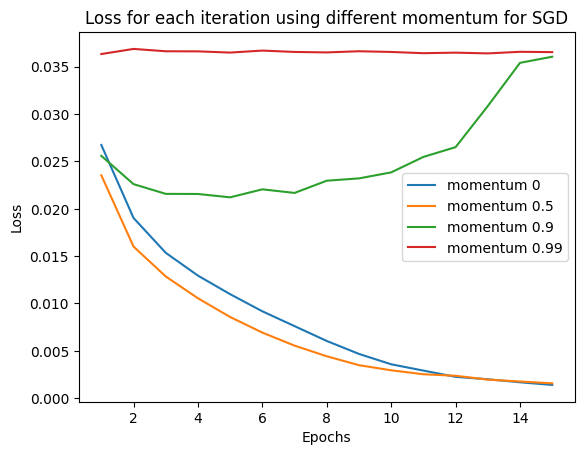

[[0.026739053999999995, 0.019031764000000007, 0.015353716000000002, 0.012943709999999999, 0.010982014000000002, 0.009175411999999992, 0.007609102, 0.006041721999999997, 0.004673554000000003, 0.0035785800000000005, 0.002914212000000001, 0.002250932000000001, 0.001997633999999999, 0.0016793819999999986, 0.0014004359999999995], [0.023538220000000006, 0.016011545999999984, 0.012857170000000018, 0.010551190000000004, 0.008573870000000003, 0.006925581999999997, 0.005548801999999999, 0.0044239760000000005, 0.0034860679999999993, 0.002945655999999999, 0.0025267439999999996, 0.002367008, 0.0019632259999999993, 0.0017619959999999985, 0.0015671560000000008], [0.02559359199999997, 0.02260533599999998, 0.021578111999999997, 0.021564628000000006, 0.021211448000000004, 0.02205782200000001, 0.021676263999999997, 0.022968715999999983, 0.02321143199999999, 0.023847644000000022, 0.02547948999999998, 0.02651297600000001, 0.030853458, 0.03541663400000001, 0.036061328000000004], [0.036344204000000026, 0.036

In [ ]:
# Comparing effect of weight initialization on training accuracy for each iteration
iterations = []
for i in range(num_epochs):
  iterations.append(i+1)

fig, ax = plt.subplots()

# Plot each line on the same graph
ax.plot(iterations, models_training_accuracy[0], label='momentum 0')
ax.plot(iterations, models_training_accuracy[1], label='momentum 0.5')
ax.plot(iterations, models_training_accuracy[2], label='momentum 0.9')
ax.plot(iterations, models_training_accuracy[3], label='momentum 0.99')

# Set labels and a legend
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss for each iteration using different momentum for SGD')
ax.legend()

# Show the plot
plt.show()

print(models_training_accuracy)



In [ ]:
for i, model in enumerate(models):
  # Evaluate the CNN model for Cifar10 dataset
  correct = 0
  total = 0

  with torch.no_grad():
      for images, labels in testloader_cifar10:
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          _, predicted = torch.max(outputs.data, dim=1)

          correct += (predicted == labels).sum().item() # .item() is to get the value attribute from a tensor object
          total += labels.size(0)

  print(f"Test Accuracy for CNN with momomentum {momentums[i]}: {(100 * correct / total)} %")




Test Accuracy for CNN with momomentum 0: 67.45 %
Test Accuracy for CNN with momomentum 0.5: 69.71 %
Test Accuracy for CNN with momomentum 0.9: 10.0 %
Test Accuracy for CNN with momomentum 0.99: 10.0 %


The convergence speed and overall loss of the training set is much better with momentum of 0 and 0.5 than with momentum 0.9 and 0.99. This is also reflected on the test accuracy with momentum 0 and 0.5 having a score of 67.45 % and 69.71 % respectively, while momentum 0.9 and 0.99 both have a score of 10.0 % on the test set.

In [ ]:
# Using Adam optimizer instead of SGD
cnn_cifar10_adam = CNN2()
cnn_cifar10_adam.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_cifar10_adam.parameters(), lr=0.001)

training_accuracy = []
# Train the CNN
num_epochs = 13
for epoch in range(num_epochs):
  for batch_id, (images, labels) in enumerate(trainloader_cifar10):
    # Move tensor to the same device (CPU/GPU) as the model
    images, labels = images.to(device), labels.to(device)

    # Forward pass
    outputs = cnn_cifar10_adam(images)
    loss = loss_func(outputs, labels)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_value = round(loss.item(), 4)

  training_accuracy.append(loss_value)

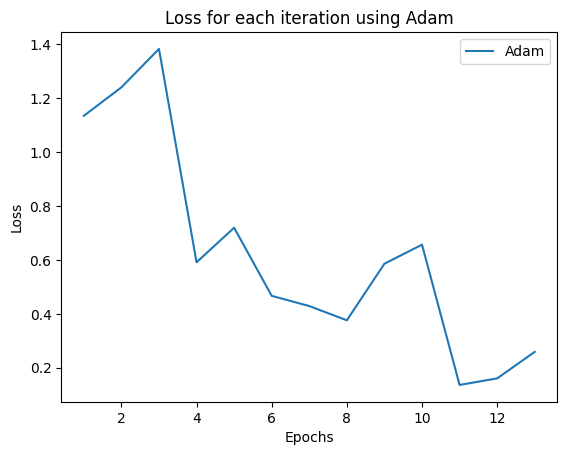

In [ ]:
# Comparing effect of weight initialization on training accuracy for each iteration
iterations = []
for i in range(num_epochs):
  iterations.append(i+1)

fig, ax = plt.subplots()

# Plot each line on the same graph
ax.plot(iterations, training_accuracy, label='Adam')


# Set labels and a legend
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss for each iteration using Adam')
ax.legend()

# Show the plot
plt.show()




In [ ]:
# Evaluate the CNN model for Cifar10 dataset
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader_cifar10:
        images, labels = images.to(device), labels.to(device)

        outputs = cnn_cifar10_adam(images)
        _, predicted = torch.max(outputs.data, dim=1)

        correct += (predicted == labels).sum().item() # .item() is to get the value attribute from a tensor object
        total += labels.size(0)

print(f"Test Accuracy for CNN with Adam: {(100 * correct / total)} %")

Test Accuracy for CNN with Adam: 70.5 %


The loss during training seems to be decreasing lower than when using SGD with momentum of 0 or 0.5, but the test accuracy is a bit higher with a score of 70.5 %.